In [1]:
import numpy as np
from scipy.optimize import brentq, fixed_point
import pint

## Raindrop shape

In order to calculate terminal velocity we need to find $\frac{a}{b}$, which is uniquely determined from $r_{eq}$ with following equation:

$$

r_{eq} = \sqrt{\frac{\sigma_{c-air}}{g(\rho_{c,l} - \rho_{air})}}\left(\frac{b}{a}\right)^{-\frac{1}{6}}\sqrt{\left(\frac{b}{a}\right)^{-2} - 2\left(\frac{b}{a}\right)^{-\frac{1}{3}} + 1}

$$

This can be done by transforming it into form $F(x) = 0$ where the variable $x = \frac{b}{a}$ and finding roots of $F$.

$$

F\left(\frac{b}{a}\right) = \sqrt{\frac{\sigma_{c-air}}{g(\rho_{c,l} - \rho_{air})}}\left(\frac{b}{a}\right)^{-\frac{1}{6}}\sqrt{\left(\frac{b}{a}\right)^{-2} - 2\left(\frac{b}{a}\right)^{-\frac{1}{3}} + 1} - r_{eq} = 0


$$

In [2]:
ureg = pint.UnitRegistry()

SIGMA_WATER_AIR = 0.073 #* ureg.newton / ureg.meter
GRAVITY = 9.81 #* ureg.meter / ureg.second**2
RHO_WATER = 1000.0 #* ureg.kilogram / ureg.meter**3
RHO_AIR = 1.205 #* ureg.kilogram / ureg.meter**3

def calculate_shape_ratio(r_eq):
    def F(x):
        return np.sqrt(SIGMA_WATER_AIR / (GRAVITY * (RHO_WATER - RHO_AIR))) * x**(-1/6) * \
               np.sqrt(x**(-2) - 2 * x**(-1/3) + 1) - r_eq
    return brentq(F, 1e-9, 1.0 - 1e-9)

r_eq = 0.004 #* ureg.meter

shape_ratio = calculate_shape_ratio(r_eq)
shape_ratio

0.5592937418316654

$$
f_{SA} = \begin{cases} 0.5 \left(\frac{b}{a}\right)^{-2/3} + \left(\frac{b}{a}\right)^{4/3} (4\epsilon)^{-1}ln\left[\frac{1 + \epsilon}{1 - \epsilon}\right], & b/a < 1 \\ 1, & b/a = 1 \end{cases}
$$,
where $\epsilon = \sqrt{1 - (b / a)^2}$

In [3]:
def calculate_fSA(shape_ratio):
    epsilon = np.sqrt(1 - shape_ratio**2)
    if shape_ratio < 1:
        return 0.5 * (shape_ratio ** (-2/3)) + shape_ratio ** (4/3) * \
            np.log((1 + epsilon) / (1 - epsilon)) / (4 * epsilon)
    elif shape_ratio == 1:
        return 1.0
    else:
        raise ValueError("Shape ratio must be in (0, 1]")

fSA = calculate_fSA(shape_ratio)
fSA

1.0658760029877963

$$

C_{shape}=1+1.5(f_{SA}-1)^{0.5}+6.7(f_{SA}-1)

$$

In [4]:
def calculate_C_shape(fSA):
    return 1 + 1.5 * (fSA - 1)**0.5 + 6.7 * (fSA - 1)

C_shape = calculate_C_shape(fSA)
C_shape

1.8263640339086842

$$
C_{D}=\left(\frac{24}{Re}\left(1+0.15Re^{0.687}\right)+0.42\left(1+4.25\times10^{4}Re^{-1.16}\right)^{-1}\right)C_{shape}
$$

In [5]:
AIR_VISCOSITY = 1.81e-5

def calculate_CD(C_shape, vT, r_eq):
    Re = vT * 2 * r_eq * RHO_AIR / AIR_VISCOSITY
    return ((24 / Re) * (1 + 0.15 * Re**0.687) + 0.42 * (1 + 4.25 * 10**4 * Re**-1.16)**-1) * C_shape

CD = calculate_CD(C_shape, 6.5, r_eq)
CD


0.7026691301393564

$$
v_{t + 1} = -\sqrt{\frac{8}{3}\frac{(\rho_{c,l} - \rho_{air})}{\rho_{air}}\frac{g}{C_D(v_{t})}\left(\frac{b}{a}\right)^{\frac{2}{3}}r_{eq}}
$$

In [6]:
def calculate_terminal_velocity(Cd, shape_ratio, r_eq):
        return np.sqrt(8/3 * ((RHO_WATER - RHO_AIR) / RHO_AIR) * (GRAVITY / Cd) * shape_ratio**(2/3) * r_eq)

def find_terminal_velocity(r_eq, C_shape, shape_ratio):
    v0 = 0.001
    def f(vT):
        vT = np.abs(vT)
        Cd = calculate_CD(C_shape, vT, r_eq)
        return calculate_terminal_velocity(Cd, shape_ratio, r_eq)

    return fixed_point(f, v0)

v_terminal = find_terminal_velocity(r_eq, C_shape, shape_ratio)
v_terminal

array(9.12916313)

In [13]:
def numerical_solultion(r_eq):
    shape_ratio = calculate_shape_ratio(r_eq)
    fSA = calculate_fSA(shape_ratio)
    C_shape = calculate_C_shape(fSA)
    v_terminal = find_terminal_velocity(r_eq, C_shape, shape_ratio)
    return v_terminal
numerical_solultion(r_eq)

array(9.12916313)

# Validation

In following sections, we will validate the solution in to ways
1. Comparison with analytic solution (for raindrop radii for which it is applicable)
2. Comparison with experimental data

## Stokes formula

For very small sizes of raindrops, vertical velocity can be derived from Stokes' Law and takes following form:

$$

v_t = \frac{2r^2g(\rho_w - \rho_{air})}{9\mu_a}

$$

In [ ]:
def analytic_terminal_velocity(r_eq):
    return (2 * r_eq ** 2 * GRAVITY * (RHO_WATER - RHO_AIR)) / (9 * AIR_VISCOSITY)

analytic_terminal_velocity(0.004)

1924.7497016574582

As can be observed from above, for big enough radius it results in obviously wrong values (1924 m/s for 4mm raindrop)

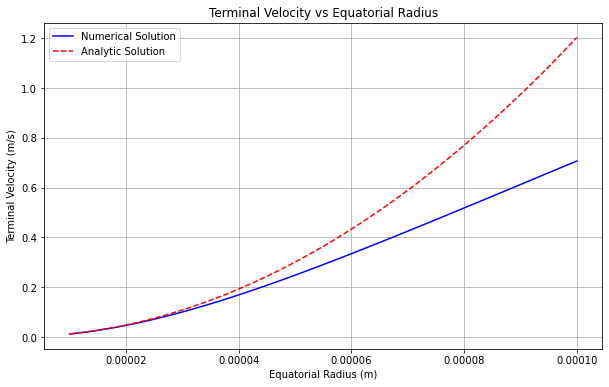

[array(0.01192565), array(0.01416861), array(0.01659797), array(0.01921163), array(0.02200733), array(0.02498266), array(0.02813512), array(0.03146205), array(0.03496071), array(0.03862823), array(0.04246167), array(0.04645798), array(0.05061404), array(0.05492667), array(0.05939263), array(0.06400862), array(0.06877129), array(0.07367727), array(0.07872315), array(0.08390552), array(0.08922092), array(0.09466593), array(0.1002371), array(0.105931), array(0.11174421), array(0.11767333), array(0.12371499), array(0.12986582), array(0.13612254), array(0.14248185), array(0.14894052), array(0.15549538), array(0.16214327), array(0.16888111), array(0.17570586), array(0.18261454), array(0.18960423), array(0.19667206), array(0.20381523), array(0.211031), array(0.21831668), array(0.22566966), array(0.23308738), array(0.24056734), array(0.24810712), array(0.25570436), array(0.26335674), array(0.27106203), array(0.27881805), array(0.28662267), array(0.29447386), array(0.3023696), array(0.31030796)

In [32]:
import matplotlib.pyplot as plt

r_eqs = np.linspace(1e-5, 1e-4, 100)
numerical_solutions = [numerical_solultion(r_eq) for r_eq in r_eqs]
analytic_solutions = [analytic_terminal_velocity(r_eq) for r_eq in r_eqs]

plt.figure(figsize=(10, 6))
plt.plot(r_eqs, numerical_solutions, label='Numerical Solution', color='blue')
plt.plot(r_eqs, analytic_solutions, label='Analytic Solution', color='red', linestyle='--')
plt.xlabel('Equatorial Radius (m)')
plt.ylabel('Terminal Velocity (m/s)')
plt.title('Terminal Velocity vs Equatorial Radius')
plt.legend()
plt.grid()
plt.show()

print(numerical_solutions)

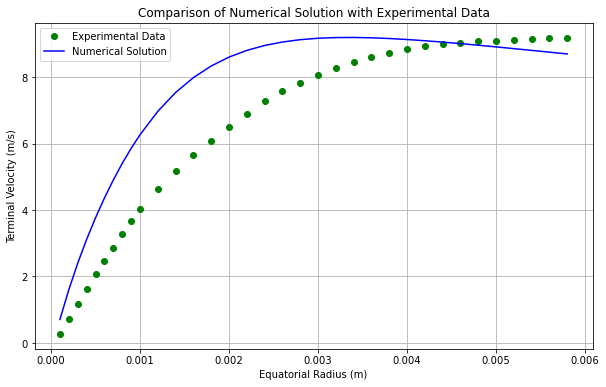

In [33]:
experimental_r_eqs = np.concatenate((np.arange(0.01, 0.11, 0.01), np.arange(0.12, 0.6, 0.02))) * 1e-2
experimental_solutions = np.array([0.27, 0.72, 1.17, 1.62, 2.06, 2.47, 2.87, 3.27, 3.67, 4.03,
                                   4.64, 5.17, 5.65, 6.09, 6.49, 6.90, 7.27, 7.57, 7.82, 8.06,
                                   8.26, 8.44, 8.60, 8.72, 8.83, 8.92, 8.98, 9.03, 9.07, 9.09,
                                   9.12, 9.14, 9.16, 9.17])
numerical_solultions = [numerical_solultion(r_eq) for r_eq in experimental_r_eqs]

plt.figure(figsize=(10, 6))
plt.plot(experimental_r_eqs, experimental_solutions, 'o', label='Experimental Data', color='green')
plt.plot(experimental_r_eqs, numerical_solultions, label='Numerical Solution', color='blue')
plt.xlabel('Equatorial Radius (m)')
plt.ylabel('Terminal Velocity (m/s)')
plt.title('Comparison of Numerical Solution with Experimental Data')
plt.legend()
plt.grid()
plt.show()